In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
def make_graphs(n=2, i=None, j=None, js=None):
    """Make a graph, recursively, by either including, or skipping an edge.
    Edges are given in lexicographical order, by construction."""
    out = []
    if i is None: # First call
        out  = [[(0,1)]+r for r in make_graphs(n=n, i=0, j=1, js=set([1]))]
    elif j<n-1:
        out += [[(i,j+1)]+r for r in make_graphs(n=n, i=i, j=j+1, js=js | set([j+1]))]
        out += [          r for r in make_graphs(n=n, i=i, j=j+1, js=js)]
    elif i<n-1:
        out = make_graphs(n=n, i=i+1, j=i+1, js=js)
    else:
        out = [[]]
    return out
                                                  
gs = make_graphs(3)
print('Drawing...')
# plot_graphs(gs)

Drawing...


In [ ]:

def perm(n, s=None):
    """All permutations of n elements."""
    if s is None: return perm(n, tuple(range(n)))
    if not s: return [[]]
    return [[i]+p for i in s for p in perm(n, tuple([k for k in s if k!=i]))]

perm(3)

[[0, 1, 2], [0, 2, 1], [1, 0, 2], [1, 2, 0], [2, 0, 1], [2, 1, 0]]

In [ ]:
def permute(g, n):
    """Create a set of all possible isomorphic codes for a graph, 
    as nice hashable tuples. All edges are i<j, and sorted lexicographically."""
    ps = perm(n)
    out = []
    for p in ps:
        out.append(tuple(sorted([(p[i],p[j]) if p[i]<p[j] else (p[j],p[i])for i,j in g])))
    return out

permute([(0, 1), (0, 2)], 3)

[((0, 1), (0, 2)),
 ((0, 1), (0, 2)),
 ((0, 1), (1, 2)),
 ((0, 1), (1, 2)),
 ((0, 2), (1, 2)),
 ((0, 2), (1, 2))]

In [ ]:
def connected(g):
    """Check if the graph is full connected, with Union-Find."""
    nodes = set([i for e in g for i in e])
    roots = {node: node for node in nodes}
    
    def _root(node, depth=0):
        if node==roots[node]: return (node, depth)
        else: return _root(roots[node], depth+1)
    
    for i,j in g:
        ri,di = _root(i)
        rj,dj = _root(j)
        if ri==rj: continue
        if di<=dj: roots[ri] = rj
        else:      roots[rj] = ri
    return len(set([_root(node)[0] for node in nodes]))==1

assert connected([(0, 1), (0, 2), (1, 3)])
assert not connected([(0, 1), (2, 3)])

In [ ]:
def filter(gs, target_nv):
    """Filter all improper graphs: those with not enough nodes, 
    those not fully connected, and those isomorphic to previously considered."""
    mem = set({})
    gs2 = []
    for g in gs:
        nv = len(set([i for e in g for i in e]))
        if nv != target_nv:
            continue
        if not connected(g):
            continue
        if tuple(sorted(g)) not in mem:
            gs2.append(g)
            mem |= set(permute(g, target_nv))
        #print('\n'.join([str(a) for a in mem]))
    return gs2
        
filter(gs, 3)

[[(0, 1), (0, 2), (1, 2)], [(0, 1), (0, 2)]]

In [ ]:
def plot_graphs(graphs, figsize=14, dotsize=20):
    """Utility to plot a lot of graphs from an array of graphs. 
    Each graphs is a list of edges; each edge is a tuple."""
    n = len(graphs)
    fig = plt.figure(figsize=(figsize,figsize))
    fig.patch.set_facecolor('white') # To make copying possible (no transparent background)
    k = int(np.sqrt(n))
    for i in range(n):
        plt.subplot(k+1,k+1,i+1)
        g = nx.Graph()
        for e in graphs[i]:            
            g.add_edge(e[0],e[1])
        nx.draw_kamada_kawai(g, node_size=dotsize)
        print('.', end='')

#plot_graphs([[(0,1),(1,2),(1,3)]])

In [ ]:
len(gs)

112

In [ ]:
NV = 6
print('Building...')
gs = make_graphs(NV)
print('Filtering...')
gs = filter(gs, NV)
print('Drawing...')

Building...
Filtering...
Drawing...


In [ ]:
graphs = gs

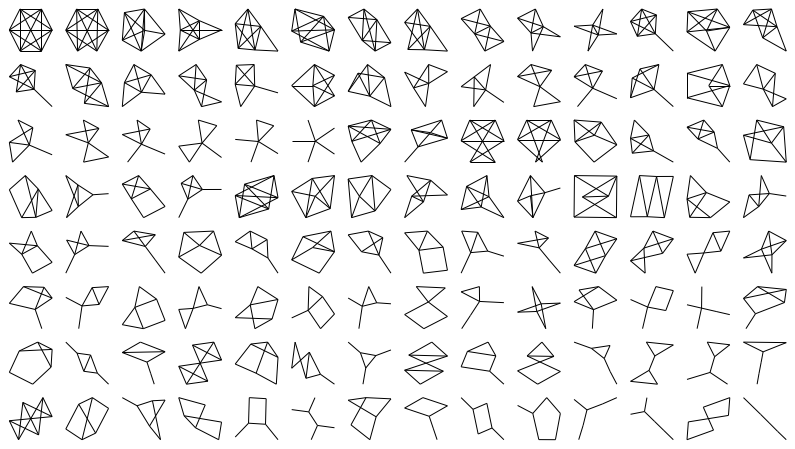

In [ ]:
n = len(graphs)
f, axs = plt.subplots(8, 14, figsize=(14, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    plt.sca(ax)
    g = nx.Graph()
    for e in graphs[i]:            
        g.add_edge(e[0],e[1])
    nx.draw_kamada_kawai(g, node_size=0)
    

In [ ]:
f.savefig('images/0019_ngraphs.svg', dpi=300)

In [ ]:
n = len(graphs)
point_sets = []
for i, ax in enumerate(axs):
    g = nx.Graph()
    for e in graphs[i]:            
        g.add_edge(e[0],e[1])
    x  = nx.kamada_kawai_layout(g)
    point_sets.append(x)


In [ ]:
from matplotlib.collections import LineCollection
import bezier
def gen_bezier(nodes, bez_eval_start=0, bez_eval_end=1, n_eval_points=1000):
    nodes = np.asfortranarray(nodes)
    curve = bezier.Curve(nodes, degree=(nodes.shape[1]-1))
    eval_points = np.linspace(bez_eval_start, bez_eval_end, n_eval_points)
    x, y = curve.evaluate_multi(eval_points)
    return np.stack([x, y])

In [ ]:
xs, ys = np.meshgrid(np.arange(8), np.arange(14))
xs = xs.flatten() * 2.5
ys = ys.flatten() * 2.5
edge_sets = []
bez_noise_scale = 0.4

for i in range(n):
    x = xs[i]
    y = ys[i]
    center = np.array([x, y])
    graph = graphs[i]
    ps = point_sets[i]
    edges = []
    for e0,e1 in graph:
        p0 = ps[e0] + center
        
        p1 = ps[e1] + center
        pmid = np.mean([p0, p1], axis=0) + np.random.randn(2) * bez_noise_scale
        edges.append(np.stack([p0, pmid, p1]).T)
    edge_sets += edges
    
bez_lines = [gen_bezier(edge).T for edge in edge_sets]

f,ax = plt.subplots(figsize=(8,14))
lc = LineCollection(bez_lines, color='k', alpha=0.2)
ax.add_collection(lc)
ax.axis('tight')
ax.axis('off')

(-2.726825548973681, 35.2633365284473, -2.1549423376360695, 19.499042743853884)

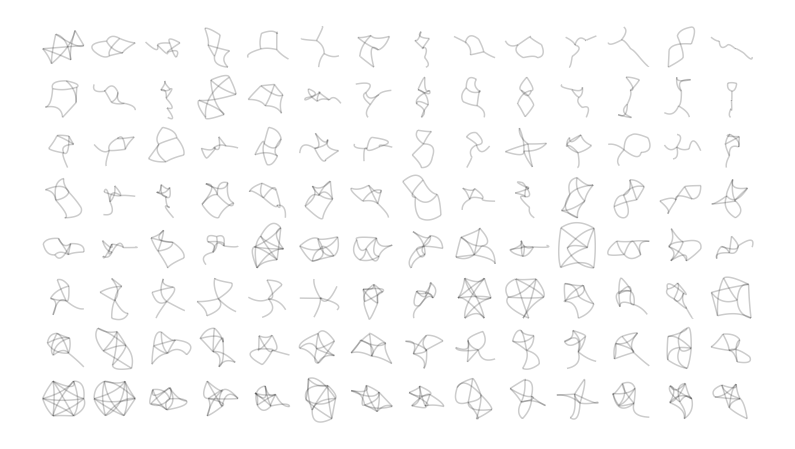

In [ ]:
xs, ys = np.meshgrid(np.arange(14), np.arange(8))
xs = xs.flatten() * 2.5
ys = ys.flatten() * 2.5
edge_sets = []
bez_noise_scale = 0.3

for i in range(n):
    x = xs[i]
    y = ys[i]
    center = np.array([x, y])
    graph = graphs[i]
    ps = point_sets[i]
    edges = []
    for e0,e1 in graph:
        p0 = ps[e0] + center
        
        p1 = ps[e1] + center
        pmid = np.mean([p0, p1], axis=0) + np.random.randn(2) * bez_noise_scale
        edges.append(np.stack([p0, pmid, p1]).T)
    edge_sets += edges
    
bez_lines = [gen_bezier(edge).T for edge in edge_sets]

f,ax = plt.subplots(figsize=(14,8))
lc = LineCollection(bez_lines, color='k', alpha=0.2)
ax.add_collection(lc)
ax.axis('tight')
ax.axis('off')

In [ ]:
from pathlib import Path
savedir = Path('/mnt/c/code/side/good_robot/images')
filename = '0055_kamada_kawaii.png'
save_filepath = savedir.joinpath(filename)
f.savefig(save_filepath)